In [99]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelBinarizer

from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, RationalQuadratic, ExpSineSquared, ConstantKernel
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from datetime import datetime

In [100]:
df_fb_metrics = pd.read_csv('dataset_Facebook.csv',sep=';')

In [101]:
print(df_fb_metrics.info())
df_fb_metrics.replace(r'^\s*$', np.nan, regex=True, inplace = True)
df_fb_metrics.replace('?', np.nan, inplace = True)
print(df_fb_metrics.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 19 columns):
Page total likes                                                       500 non-null int64
Type                                                                   500 non-null object
Category                                                               500 non-null int64
Post Month                                                             500 non-null int64
Post Weekday                                                           500 non-null int64
Post Hour                                                              500 non-null int64
Paid                                                                   499 non-null float64
Lifetime Post Total Reach                                              500 non-null int64
Lifetime Post Total Impressions                                        500 non-null int64
Lifetime Engaged Users                                                 500 non-nul

In [102]:
#Since we are going to consider Total Interactions as the output variable (being the sum of Comment , Like, Share) 
#we can drop Comment , Like, Share and the null values associated with them.
individual_interaction_components = ['comment','like','share']
df_fb_metrics = df_fb_metrics.drop(columns=individual_interaction_components, axis=1)
df_fb_metrics.head()

,Page total likes,Type,Category,Post Month,Post Weekday,Post Hour,Paid,Lifetime Post Total Reach,Lifetime Post Total Impressions,Lifetime Engaged Users,Lifetime Post Consumers,Lifetime Post Consumptions,Lifetime Post Impressions by people who have liked your Page,Lifetime Post reach by people who like your Page,Lifetime People who have liked your Page and engaged with your post,Total Interactions
0,139441,Photo,2,12,4,3,0.0,2752,5091,178,109,159,3078,1640,119,100
1,139441,Status,2,12,3,10,0.0,10460,19057,1457,1361,1674,11710,6112,1108,164
2,139441,Photo,3,12,3,3,0.0,2413,4373,177,113,154,2812,1503,132,80
3,139441,Photo,2,12,2,10,1.0,50128,87991,2211,790,1119,61027,32048,1386,1777
4,139441,Photo,2,12,2,3,0.0,7244,13594,671,410,580,6228,3200,396,393


In [103]:
#We now have a categorical input variable Type.
df_fb_metrics["Type"].value_counts()

Photo     426
Status     45
Link       22
Video       7
Name: Type, dtype: int64

In [104]:
#With just 4 different types of values we can plan to use OneHotEncoding which would add 4 new columns to our dataframe 
lb_style = LabelBinarizer()
lb_results = lb_style.fit_transform(df_fb_metrics["Type"])
encoded_df = pd.DataFrame(lb_results, columns=lb_style.classes_)
df_fb_metrics = pd.concat([df_fb_metrics,encoded_df], axis=1) 
cols = list(df_fb_metrics)
cols.insert(1, cols.pop(cols.index('Link')))
cols.insert(2, cols.pop(cols.index('Photo')))
cols.insert(3, cols.pop(cols.index('Status')))
cols.insert(4, cols.pop(cols.index('Video')))
df_fb_metrics = df_fb_metrics.loc[:, cols]
df_fb_metrics = df_fb_metrics.drop(columns=['Type'],axis=1)
df_fb_metrics.head()

,Page total likes,Link,Photo,Status,Video,Category,Post Month,Post Weekday,Post Hour,Paid,Lifetime Post Total Reach,Lifetime Post Total Impressions,Lifetime Engaged Users,Lifetime Post Consumers,Lifetime Post Consumptions,Lifetime Post Impressions by people who have liked your Page,Lifetime Post reach by people who like your Page,Lifetime People who have liked your Page and engaged with your post,Total Interactions
0,139441,0,1,0,0,2,12,4,3,0.0,2752,5091,178,109,159,3078,1640,119,100
1,139441,0,0,1,0,2,12,3,10,0.0,10460,19057,1457,1361,1674,11710,6112,1108,164
2,139441,0,1,0,0,3,12,3,3,0.0,2413,4373,177,113,154,2812,1503,132,80
3,139441,0,1,0,0,2,12,2,10,1.0,50128,87991,2211,790,1119,61027,32048,1386,1777
4,139441,0,1,0,0,2,12,2,3,0.0,7244,13594,671,410,580,6228,3200,396,393


In [105]:
#We now have a categorical input variable Type.
df_fb_metrics["Paid"].value_counts()

0.0    360
1.0    139
Name: Paid, dtype: int64

In [106]:
df_fb_metrics[df_fb_metrics.isna().any(axis=1)]

,Page total likes,Link,Photo,Status,Video,Category,Post Month,Post Weekday,Post Hour,Paid,Lifetime Post Total Reach,Lifetime Post Total Impressions,Lifetime Engaged Users,Lifetime Post Consumers,Lifetime Post Consumptions,Lifetime Post Impressions by people who have liked your Page,Lifetime Post reach by people who like your Page,Lifetime People who have liked your Page and engaged with your post,Total Interactions
499,81370,0,1,0,0,2,1,4,4,NaN,4188,7292,564,524,743,3861,2200,316,119


In [107]:
#Fill missing value with most common value
df_fb_metrics = df_fb_metrics.apply(lambda x: x.fillna(x.value_counts().index[0]))
df_fb_metrics.shape

(500, 19)

In [108]:
#Preparing the training and testing dataset.
X_train, X_test, y_train, y_test = train_test_split(df_fb_metrics.iloc[:, 0:18].values, df_fb_metrics.iloc[:, 18].values, test_size=0.33, random_state=0)
#Standardising the data set
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

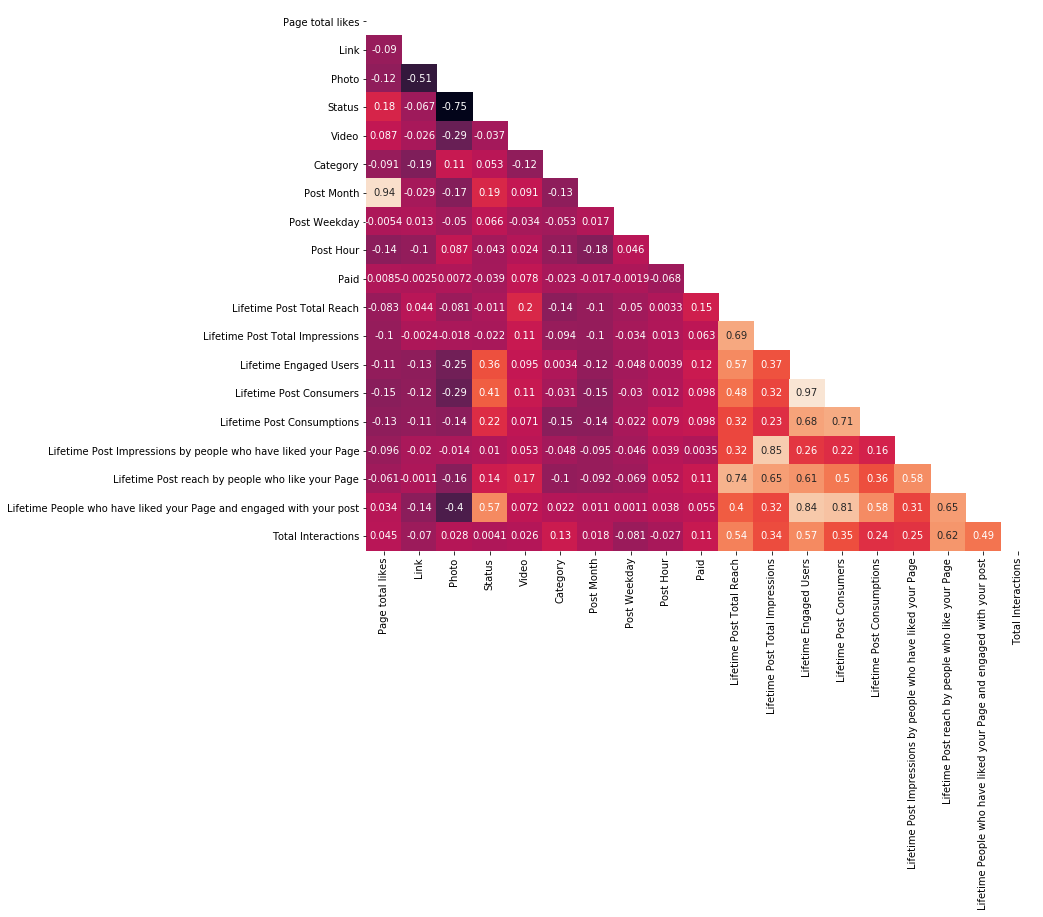

In [109]:
plt.figure(figsize=(12,10))
df_fb_metrics_corr = df_fb_metrics.corr()
mask = np.zeros_like(df_fb_metrics_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(df_fb_metrics_corr,annot=True,cbar=False, mask=mask)

In [110]:
#Running the dataset across various regressors

In [111]:
def svr_param_selection(X, y, nfolds):
    Kernels = ['linear', 'poly', 'rbf']
    Cs = [0.001, 0.01, 0.1, 1]
    Gammas = [0.001, 0.01, 0.1]
    param_grid = {'kernel':Kernels, 'C': Cs, 'gamma' : Gammas}
    grid_search = GridSearchCV(SVR(), param_grid, cv=nfolds, n_jobs=-1, iid=False)
    grid_search.fit(X, y)
    print('SVR Lowest MSE Score: '+str(grid_search.best_score_))
    print('SVR With Parameters: '+str(grid_search.best_params_))    
    return grid_search.best_params_

In [112]:
def random_forest_regressor_param_selection(X, y, nfolds):
    Estimators = np.arange(1,100,15)
    Max_features = ['auto', 'sqrt']
    Min_samples_leafs = np.linspace(0.01, 0.05, 5, endpoint=True)
    param_grid = {'n_estimators': Estimators, 'max_features': Max_features, 'min_samples_leaf': Min_samples_leafs}
    grid_search = GridSearchCV(RandomForestRegressor(random_state=0), param_grid, cv=nfolds, n_jobs=-1, iid=False)
    grid_search.fit(X, y)
    print('RandomForestRegressor Lowest MSE Score: '+str(grid_search.best_score_))
    print('RandomForestRegressor With Parameters: '+str(grid_search.best_params_))    
    return grid_search.best_params_

In [113]:
def decision_tree_regressor_param_selection(X, y, nfolds):
    Max_features = ['auto', 'sqrt']
    Min_samples_leafs = np.linspace(0.01, 0.05, 5, endpoint=True)
    param_grid = {'max_features': Max_features, 'min_samples_leaf': Min_samples_leafs}
    grid_search = GridSearchCV(DecisionTreeRegressor(random_state=0), param_grid, cv=nfolds, n_jobs=-1, iid=False)
    grid_search.fit(X, y)
    print('DecisionTreeRegressor Lowest MSE Score: '+str(grid_search.best_score_))
    print('DecisionTreeRegressor With Parameters: '+str(grid_search.best_params_))    
    return grid_search.best_params_

In [114]:
def ada_boost_regressor_param_selection(X, y, nfolds):
    Estimators = np.arange(1,100,15)
    Learning_rates = [0.01,0.05,0.1,0.3]
    Losses = ['linear', 'square', 'exponential']
    param_grid = {'n_estimators': Estimators, 'learning_rate': Learning_rates, 'loss': Losses}
    grid_search = GridSearchCV(AdaBoostRegressor(base_estimator=DecisionTreeRegressor(random_state=0),random_state=0), param_grid, cv=nfolds, n_jobs=-1, iid=False)
    grid_search.fit(X, y)
    print('AdaBoostRegressor Lowest MSE Score:'+str(grid_search.best_score_))
    print('AdaBoostRegressor With Parameters:'+str(grid_search.best_params_))    
    return grid_search.best_params_

In [115]:
def gaussian_regressor_param_selection(X, y, nfolds):
    kernel_rbf = ConstantKernel(1.0, constant_value_bounds="fixed") * RBF(1.0, length_scale_bounds="fixed")
    kernel_rq = ConstantKernel(1.0, constant_value_bounds="fixed") * RationalQuadratic(alpha=0.1, length_scale=1)
    kernel_expsine = ConstantKernel(1.0, constant_value_bounds="fixed") * ExpSineSquared(1.0, 5.0, periodicity_bounds=(1e-2, 1e1))
    Kernels = [kernel_rbf, kernel_rq, kernel_expsine]
    param_grid = {'kernel': Kernels}
    grid_search = GridSearchCV(GaussianProcessRegressor(random_state=0), param_grid, cv=nfolds, n_jobs=-1, iid=False)
    grid_search.fit(X, y)
    print('GaussianRegressor Lowest MSE Score:'+str(grid_search.best_score_))
    print('GaussianRegressor With Parameters:'+str(grid_search.best_params_))    
    return grid_search.best_params_

In [116]:
def linear_regressor_param_selection(X, y, nfolds):
    param_grid = {'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False]}
    grid_search = GridSearchCV(LinearRegression(), param_grid, cv=nfolds, n_jobs=-1, iid=False)
    grid_search.fit(X, y)
    print('LinearRegressor Lowest MSE Score:'+str(grid_search.best_score_))
    print('LinearRegressor With Parameters:'+str(grid_search.best_params_))    
    return grid_search.best_params_

In [117]:
def neural_network_regressor_param_selection(X, y, nfolds):
    Learning_rates = ['constant','adaptive']
    Learning_rates_init = [0.001, 0.01, 0.1, 0.3]
    Hidden_Layer_Sizes = [1, 5, 10, (5,5), (10,5)]
    Activations = ['logistic', 'tanh', 'relu']
    Alphas = [0.0001,0.002]
    param_grid = {'learning_rate': Learning_rates, 'learning_rate_init': Learning_rates_init, 'hidden_layer_sizes': Hidden_Layer_Sizes, 'activation': Activations, 'alpha': Alphas}
    grid_search = GridSearchCV(MLPRegressor(max_iter=900), param_grid, cv=nfolds, n_jobs=-1, iid=False)
    grid_search.fit(X, y)
    print('NeuralNetworkRegressor Lowest MSE Score:'+str(grid_search.best_score_))
    print('NeuralNetworkRegressor With Parameters:'+str(grid_search.best_params_))    
    return grid_search.best_params_

In [118]:
#Using the 3-Fold HyperParam Search to evaluate the best hyperparams for each model
print("now ="+str(datetime.now()))
svr_best_param           = svr_param_selection(X_train_scaled, y_train, 3)
print("now ="+str(datetime.now()))
random_forest_best_param = random_forest_regressor_param_selection(X_train_scaled, y_train, 3)
print("now ="+str(datetime.now()))
decision_tree_best_param = decision_tree_regressor_param_selection(X_train_scaled, y_train, 3)
print("now ="+str(datetime.now()))
ada_boost_best_param     = ada_boost_regressor_param_selection(X_train_scaled, y_train, 3)
print("now ="+str(datetime.now()))
linear_best_param         = linear_regressor_param_selection(X_train_scaled, y_train, 3)
print("now ="+str(datetime.now()))
neural_network_best_param = neural_network_regressor_param_selection(X_train_scaled, y_train, 3)
print("now ="+str(datetime.now()))
#gaussian_best_param       = gaussian_regressor_param_selection(x_train_scaled, y_train, 3)
#print("now ="+str(datetime.now()))

now =2019-11-05 13:00:52.471889
SVR Lowest MSE Score: 0.2267192767888381
SVR With Parameters: {'C': 1, 'gamma': 0.001, 'kernel': 'linear'}
now =2019-11-05 13:00:57.321739
RandomForestRegressor Lowest MSE Score: 0.4044853712714526
RandomForestRegressor With Parameters: {'max_features': 'sqrt', 'min_samples_leaf': 0.04, 'n_estimators': 31}
now =2019-11-05 13:01:04.726675
DecisionTreeRegressor Lowest MSE Score: 0.28752277069577076
DecisionTreeRegressor With Parameters: {'max_features': 'sqrt', 'min_samples_leaf': 0.03}
now =2019-11-05 13:01:04.804797
AdaBoostRegressor Lowest MSE Score:0.5016436553402207
AdaBoostRegressor With Parameters:{'learning_rate': 0.3, 'loss': 'exponential', 'n_estimators': 16}
now =2019-11-05 13:01:31.729592
LinearRegressor Lowest MSE Score:0.9321961042521462
LinearRegressor With Parameters:{'copy_X': True, 'fit_intercept': True, 'normalize': False}
now =2019-11-05 13:01:31.889500
NeuralNetworkRegressor Lowest MSE Score:0.8566180004875257
NeuralNetworkRegressor Wi

In [119]:
#Checking MSE of each of the best regressors on test data
best_svr = SVR(C=1, gamma=0.001, kernel='linear')
best_svr.fit(X_train_scaled, y_train)
y_pred = best_svr.predict(X_test_scaled)
print('MSE for SVR: '+str(mean_squared_error(y_test, y_pred)))

MSE for SVR: 33350.52712793564


In [120]:
best_decision_tree_regressor = DecisionTreeRegressor(max_features='sqrt', min_samples_leaf=0.03, random_state=0)
best_decision_tree_regressor.fit(X_train_scaled, y_train)
y_pred = best_decision_tree_regressor.predict(X_test_scaled)
print('MSE for Decision Tree Regressor: '+str(mean_squared_error(y_test, y_pred)))

MSE for Decision Tree Regressor: 52284.59943315354


In [121]:
best_random_forest_regressor = RandomForestRegressor(max_features='sqrt', min_samples_leaf=0.04, n_estimators=31, random_state=0)
best_random_forest_regressor.fit(X_train_scaled, y_train)
y_pred = best_random_forest_regressor.predict(X_test_scaled)
print('MSE for Random Forest Regressor: '+str(mean_squared_error(y_test, y_pred)))

MSE for Random Forest Regressor: 28521.87742583811


In [122]:
best_ada_boost_regressor = AdaBoostRegressor(learning_rate=0.03, loss='exponential', n_estimators=16, random_state=0)
best_ada_boost_regressor.fit(X_train_scaled, y_train)
y_pred = best_ada_boost_regressor.predict(X_test_scaled)
print('MSE for AdaBoost Regressor: '+str(mean_squared_error(y_test, y_pred)))

MSE for AdaBoost Regressor: 27948.956750707002


In [123]:
best_linear_regressor = LinearRegression(copy_X=True, fit_intercept=True, normalize=False)
best_linear_regressor.fit(X_train_scaled, y_train)
y_pred = best_linear_regressor.predict(X_test_scaled)
print('MSE for Linear Regressor: '+str(mean_squared_error(y_test, y_pred)))

MSE for Linear Regressor: 4194.209974214472


In [127]:
best_neural_network_regressor = MLPRegressor(max_iter=900, activation='relu', alpha=0.0001, hidden_layer_sizes=(5,), learning_rate='adaptive', learning_rate_init=0.1, random_state=0)
best_neural_network_regressor.fit(X_train_scaled, y_train)
y_pred = best_neural_network_regressor.predict(X_test_scaled)
print('MSE for Neural Network Regressor: '+str(mean_squared_error(y_test, y_pred)))

MSE for Neural Network Regressor: 7453.0181551513715
